In [ ]:
!pip install -qq transformers
!pip install sentencepiece

     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.6 MB/s 
     |████████████████████████████████| 895 kB 44.3 MB/s 
     |████████████████████████████████| 636 kB 47.3 MB/s 
     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [ ]:
import transformers
from transformers import XLNetForSequenceClassification, XLNetTokenizer, AdamW, get_linear_schedule_with_warmup
# Try XLNetForSequenceClassification
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
reviews_df = pd.read_csv("reviews_preprocessed.csv")
reviews_df.head()

,content,score,thumbsUpCount,appId,review_len,word_count,polarity
0,user interface horrible way task show difficul...,0,145,com.anydo,242,40,0.031481
1,keep lose event save enter recur event might s...,0,2,com.anydo,128,22,0.000000
2,adhd want try app help remember chore around h...,0,0,com.anydo,139,22,0.500000
3,point pay premium colour tag dont even show ca...,0,3,com.anydo,123,21,0.000000
4,installed look around instal clunky feel intui...,0,1,com.anydo,136,20,0.100000


In [ ]:
class_names = ['strongly_neg','neg','neutral','pos','strongly_pos']

In [ ]:
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['▁When', '▁was', '▁I', '▁last', '▁outside', '?', '▁I', '▁am', '▁stuck', '▁at', '▁home', '▁for', '▁2', '▁weeks', '.']
Token IDs: [311, 30, 35, 129, 684, 82, 35, 569, 5388, 38, 192, 28, 159, 754, 9]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  truncation=True,
  max_length=32,
  add_special_tokens=True, # Add '<CLS>' and '<SEP>'
  return_token_type_ids=False,
#  pad_to_max_length=True, deprecated
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
reviews_df["more_than_1_star"] = reviews_df.score.apply(lambda x: 1 if (x+1 > 1) else 0)
reviews_df["more_than_2_star"] = reviews_df.score.apply(lambda x: 1 if (x+1 > 2) else 0)
reviews_df["more_than_3_star"] = reviews_df.score.apply(lambda x: 1 if (x+1 > 3) else 0)
reviews_df["more_than_4_star"] = reviews_df.score.apply(lambda x: 1 if (x+1 > 4) else 0)

In [ ]:
# Split into training and testing data
reviews_df = reviews_df[['content', 'score', 'more_than_1_star', 'more_than_2_star', 'more_than_3_star', 'more_than_4_star']]
train_dataset, test_dataset = train_test_split(reviews_df, test_size=0.16, random_state=42)

In [ ]:
train_dataset, val_dataset = train_test_split(
  train_dataset,
  test_size=0.15,
  random_state=42
)
train_dataset.shape, val_dataset.shape, test_dataset.shape

((8481, 6), (1497, 6), (1901, 6))

In [ ]:
train_dataset.head()

,content,score,more_than_1_star,more_than_2_star,more_than_3_star,more_than_4_star
9184,planner link calendar one place thing color co...,3,1,1,1,0
2612,great app ever find search feature since year ...,4,1,1,1,1
5117,great tool start track keep habit since start ...,3,1,1,1,0
1046,reminder available pro instant uninstall like ...,0,0,0,0,0
10812,like let switch calendar origin pro homescreen...,3,1,1,1,0


In [ ]:
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
train_dataset.head()

,content,score,more_than_1_star,more_than_2_star,more_than_3_star,more_than_4_star
0,like bit complicated wish example could take i...,2,1,1,0,0
1,update would make sense schedule tab schedule ...,3,1,1,1,0
2,widget doesnt work properly work open app firs...,0,0,0,0,0
3,useless login outlook account daily basis one ...,0,0,0,0,0
4,app warn trial choose cancel contact support t...,0,0,0,0,0


In [ ]:
len(train_dataset)

8481

In [ ]:
test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
val_dataset = val_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
def create_data_loader(reviews, targets, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=reviews,#df.content.to_numpy(),
    targets=targets,#df.score.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
class SentimentClassifier(nn.Module):
# def __init__(self, n_classes):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.xlnet = XLNetForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False, num_labels= n_classes)
#   self.drop = nn.Dropout(p=0.3)
#   self.out = nn.Linear(self.xlnet.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    
    output = self.xlnet(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
#    print(output[0])
#   output = self.drop(pooled_output)
#   return self.out(output)
    return output[0]

In [ ]:
BATCH_SIZE = 16

##### Classifier 1

In [ ]:
train_data_loader = create_data_loader(train_dataset.content.to_numpy(), train_dataset.more_than_1_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_dataset.content.to_numpy(), val_dataset.more_than_1_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset.content.to_numpy(), test_dataset.more_than_1_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [ ]:
xlnet_model = XLNetForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False, num_labels=2)

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
output = xlnet_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

output[0]

tensor([[0.0087, 0.3095]], grad_fn=<AddmmBackward>)

In [ ]:
nn.functional.softmax(output[0], dim=1)

tensor([[0.4254, 0.5746]], grad_fn=<SoftmaxBackward>)

In [ ]:
xlnet_model.config.return_dict

False

In [ ]:
xlnet_model.config.num_labels

2

In [ ]:
model1 = SentimentClassifier(2)
model1 = model1.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


In [ ]:
nn.functional.softmax(model1(input_ids, attention_mask), dim=1)

tensor([[0.3373, 0.6627],
        [0.4239, 0.5761],
        [0.2885, 0.7115],
        [0.6389, 0.3611],
        [0.4006, 0.5994],
        [0.2234, 0.7766],
        [0.2911, 0.7089],
        [0.2313, 0.7687],
        [0.3203, 0.6797],
        [0.2772, 0.7228],
        [0.2518, 0.7482],
        [0.4478, 0.5522],
        [0.5835, 0.4165],
        [0.2589, 0.7411],
        [0.4636, 0.5364],
        [0.3071, 0.6929]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 8
optimizer = AdamW(model1.parameters(), lr=7e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(
    model1,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_dataset)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')  

  val_acc, val_loss = eval_model(
    model1,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
     
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model1.state_dict(), 'best_model1_state.bin')
    best_accuracy = val_acc

Epoch 1/8
------------------------------
Train loss 0.5108324128524059 accuracy 0.7976653696498054
Val   loss 0.49338358989421355 accuracy 0.8076152304609219

Epoch 2/8
------------------------------
Train loss 0.47027851693093664 accuracy 0.802145973352199
Val   loss 0.3949274683886386 accuracy 0.8249832999331997

Epoch 3/8
------------------------------
Train loss 0.3841379361399037 accuracy 0.8283221318240773
Val   loss 0.3993378406826486 accuracy 0.8396793587174349

Epoch 4/8
------------------------------
Train loss 0.3573613910323707 accuracy 0.8428251385449829
Val   loss 0.36747228647483154 accuracy 0.8463593854375419

Epoch 5/8
------------------------------
Train loss 0.33797637243069384 accuracy 0.854144558424714
Val   loss 0.35463459853162155 accuracy 0.8463593854375419

Epoch 6/8
------------------------------
Train loss 0.31572696754600144 accuracy 0.8638132295719844
Val   loss 0.3829694572598376 accuracy 0.8410153640614563

Epoch 7/8
------------------------------
Train l

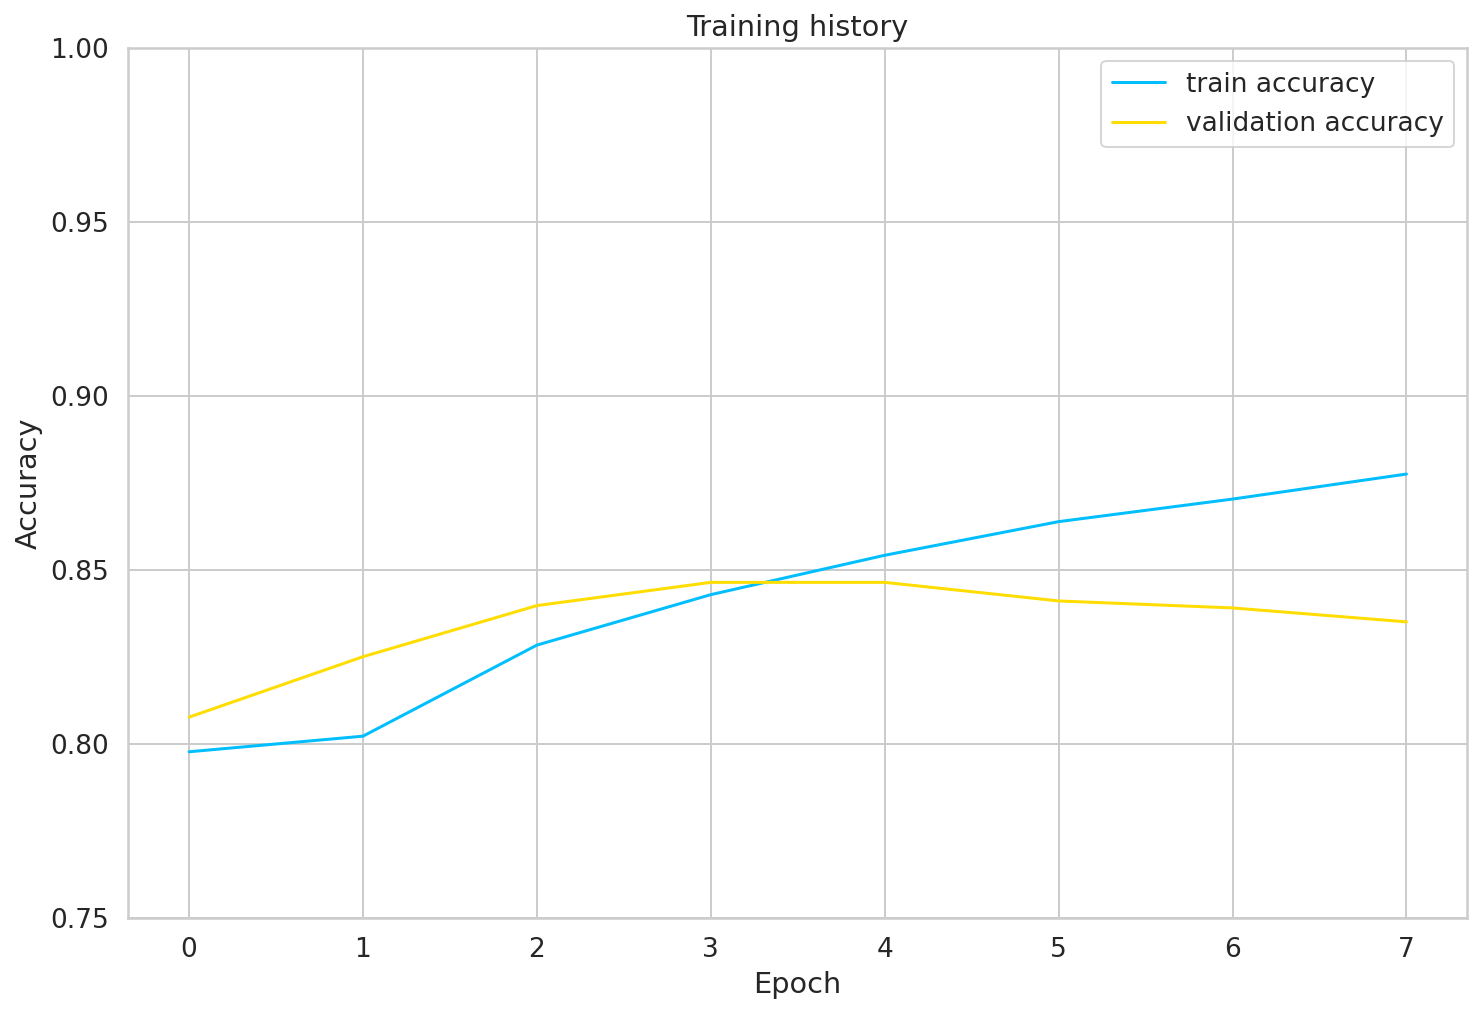

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.75, 1.0]);
# Explain why you run only 7 epochs and stop the running

In [ ]:
model1 = SentimentClassifier(2)
model1.load_state_dict(torch.load('best_model1_state.bin'))
model1 = model1.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
test_acc, test_loss = eval_model(
  model1,
  test_data_loader,
  loss_fn,
  device,
  len(test_dataset)
)

In [ ]:
test_acc.item()

0.8574434508153603

In [ ]:
test_loss

0.34439508244395256

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  enter = True
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      if(enter):
        print(outputs)
        enter = False


      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      softmax_outputs = nn.functional.softmax(outputs, dim=1)
      prediction_probs.extend(softmax_outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y1_pred, y1_pred_proba, y1_test = get_predictions(
  model1,
  test_data_loader
)

tensor([[-1.1412,  1.1584],
        [-1.6786,  1.6926],
        [-1.1530,  1.1582],
        [-0.9154,  0.9118],
        [-0.3056,  0.2924],
        [ 0.5022, -0.5244],
        [-0.8544,  0.8398],
        [-1.8481,  1.8601],
        [-1.5880,  1.6017],
        [-0.9476,  0.9401],
        [-1.8817,  1.8896],
        [-1.2153,  1.2259],
        [-0.9311,  0.9343],
        [ 0.6017, -0.6414],
        [-1.7009,  1.7144],
        [-1.6867,  1.6993]], device='cuda:0')


In [ ]:
y1_pred

tensor([1, 1, 1,  ..., 1, 1, 1])

In [ ]:
y1_pred_proba

tensor([[0.0912, 0.9088],
        [0.0332, 0.9668],
        [0.0902, 0.9098],
        ...,
        [0.3176, 0.6824],
        [0.0296, 0.9704],
        [0.0247, 0.9753]])

In [ ]:
y1_test

tensor([1, 1, 1,  ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_mx = confusion_matrix(y1_test, y1_pred)

In [ ]:
conf_mx

array([[ 156,  187],
       [  84, 1474]])

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision1 = precision_score(y1_test, y1_pred)

In [ ]:
precision1

0.8874172185430463

In [ ]:
recall1 = recall_score(y1_test, y1_pred)

In [ ]:
recall1

0.9460847240051348

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score1 = f1_score(y1_test, y1_pred)
f1_score1

0.9158123640882262

##### Classifier 2

In [ ]:
train_data_loader = create_data_loader(train_dataset.content.to_numpy(), train_dataset.more_than_2_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_dataset.content.to_numpy(), val_dataset.more_than_2_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset.content.to_numpy(), test_dataset.more_than_2_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model2 = SentimentClassifier(2)
model2 = model2.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
EPOCHS = 8
optimizer = AdamW(model2.parameters(), lr=7e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(
    model2,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_dataset)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')  

  val_acc, val_loss = eval_model(
    model2,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
    
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model2.state_dict(), 'best_model2_state.bin')
    best_accuracy = val_acc

Epoch 1/8
------------------------------
Train loss 0.497883971899804 accuracy 0.7587548638132295
Val   loss 0.42177107311943746 accuracy 0.8022712090848364

Epoch 2/8
------------------------------
Train loss 0.40808509871812637 accuracy 0.8161773375781157
Val   loss 0.4123673546821513 accuracy 0.8016032064128257

Epoch 3/8
------------------------------
Train loss 0.3602248336733959 accuracy 0.8415281216837637
Val   loss 0.4489155637615539 accuracy 0.8016032064128257

Epoch 4/8
------------------------------
Train loss 0.3202628890445312 accuracy 0.8648744251857092
Val   loss 0.47859387908210144 accuracy 0.8042752171008685

Epoch 5/8
------------------------------
Train loss 0.2862223548351624 accuracy 0.8868058012026884
Val   loss 0.5468708721405648 accuracy 0.8002672010688043

Epoch 6/8
------------------------------
Train loss 0.2627398600265131 accuracy 0.8996580591911331
Val   loss 0.6426521565844404 accuracy 0.8009352037408151

Epoch 7/8
------------------------------
Train los

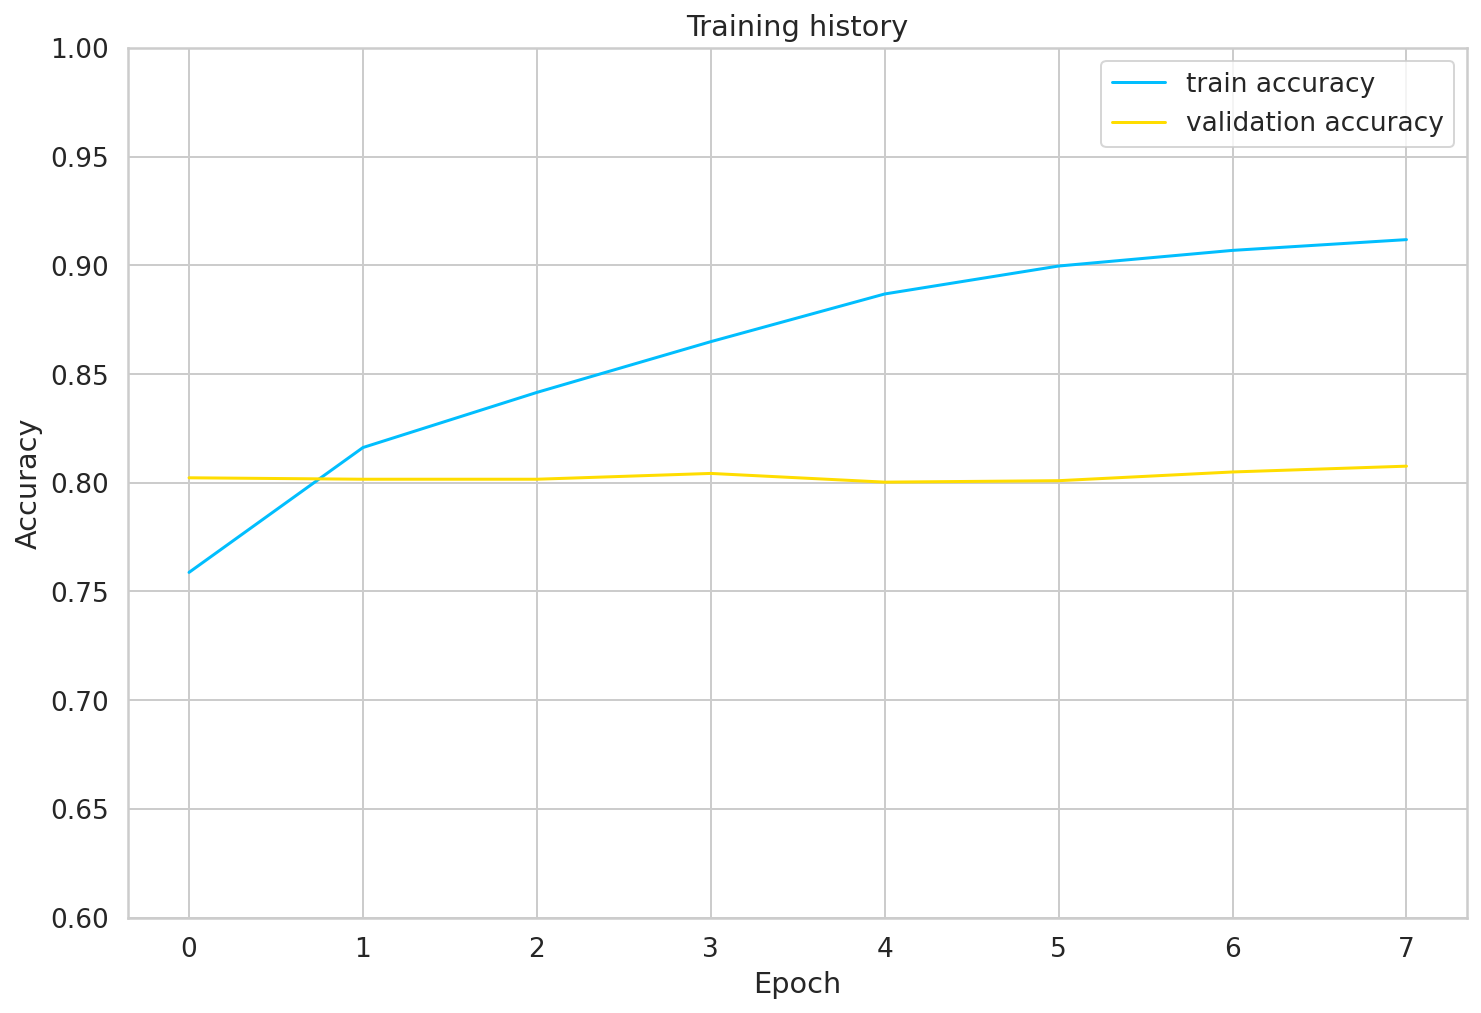

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.6, 1.0]);

In [ ]:
model2 = SentimentClassifier(2)
model2.load_state_dict(torch.load('best_model2_state.bin'))
model2 = model2.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
test_acc, test_loss = eval_model(
  model2,
  test_data_loader,
  loss_fn,
  device,
  len(test_dataset)
)

In [ ]:
test_acc.item()

0.7990531299316149

In [ ]:
test_loss

0.6695446862893946

In [ ]:
y_review_texts, y2_pred, y2_pred_proba, y2_test = get_predictions(
  model2,
  test_data_loader
)

tensor([[ 2.4220, -1.9541],
        [-2.3215,  2.9212],
        [-0.0649,  0.7781],
        [ 0.7253,  0.2448],
        [ 1.8509, -2.2503],
        [ 2.4891, -3.2335],
        [ 0.9779, -0.8791],
        [-2.3514,  3.0045],
        [-2.7112,  3.1378],
        [ 1.3029, -1.1479],
        [-2.6627,  3.0056],
        [-1.3938,  2.6075],
        [ 1.3733, -1.0785],
        [ 2.1834, -1.6286],
        [-3.0527,  3.1122],
        [-2.1905,  2.9524]], device='cuda:0')


In [ ]:
y2_pred

tensor([0, 1, 1,  ..., 0, 1, 1])

In [ ]:
y2_pred_proba

tensor([[0.9876, 0.0124],
        [0.0053, 0.9947],
        [0.3009, 0.6991],
        ...,
        [0.9819, 0.0181],
        [0.0047, 0.9953],
        [0.0010, 0.9990]])

In [ ]:
y2_test

tensor([1, 1, 1,  ..., 1, 1, 1])

In [ ]:
conf_mx = confusion_matrix(y2_test, y2_pred)

In [ ]:
conf_mx

array([[533, 186],
       [196, 986]])

In [ ]:
precision2 = precision_score(y2_test, y2_pred)

In [ ]:
precision2

0.841296928327645

In [ ]:
recall2 = recall_score(y2_test, y2_pred)

In [ ]:
recall2

0.8341793570219966

In [ ]:
f1_score2 = f1_score(y2_test, y2_pred)
f1_score2

0.8377230246389125

##### Classifier 3

In [ ]:
train_data_loader = create_data_loader(train_dataset.content.to_numpy(), train_dataset.more_than_3_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_dataset.content.to_numpy(), val_dataset.more_than_3_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset.content.to_numpy(), test_dataset.more_than_3_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model3 = SentimentClassifier(2)
model3 = model3.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
EPOCHS = 8
optimizer = AdamW(model3.parameters(), lr=7e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(
    model3,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_dataset)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')  

  val_acc, val_loss = eval_model(
    model3,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  
  PATH = 'train_valid-epoch{}.pth'.format(epoch)
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model3.state_dict(), 'best_model3_state.bin')
    best_accuracy = val_acc

Epoch 1/8
------------------------------
Train loss 0.47484472890694934 accuracy 0.7790354910977478
Val   loss 0.36186749725899797 accuracy 0.8363393453573815

Epoch 2/8
------------------------------
Train loss 0.3555050216538028 accuracy 0.8552057540384388
Val   loss 0.3851914003768817 accuracy 0.8530394121576487

Epoch 3/8
------------------------------
Train loss 0.3098638148788931 accuracy 0.8807923593915812
Val   loss 0.41430148593288785 accuracy 0.8476953907815632

Epoch 4/8
------------------------------
Train loss 0.2715993264554991 accuracy 0.8991864166961443
Val   loss 0.4380058974939141 accuracy 0.850367401469606

Epoch 5/8
------------------------------
Train loss 0.2455708487722286 accuracy 0.9127461384270722
Val   loss 0.48376959864486085 accuracy 0.8476953907815632

Epoch 6/8
------------------------------
Train loss 0.22497219628814025 accuracy 0.9225327201980899
Val   loss 0.5371656931659325 accuracy 0.8450233800935204

Epoch 7/8
------------------------------
Train l

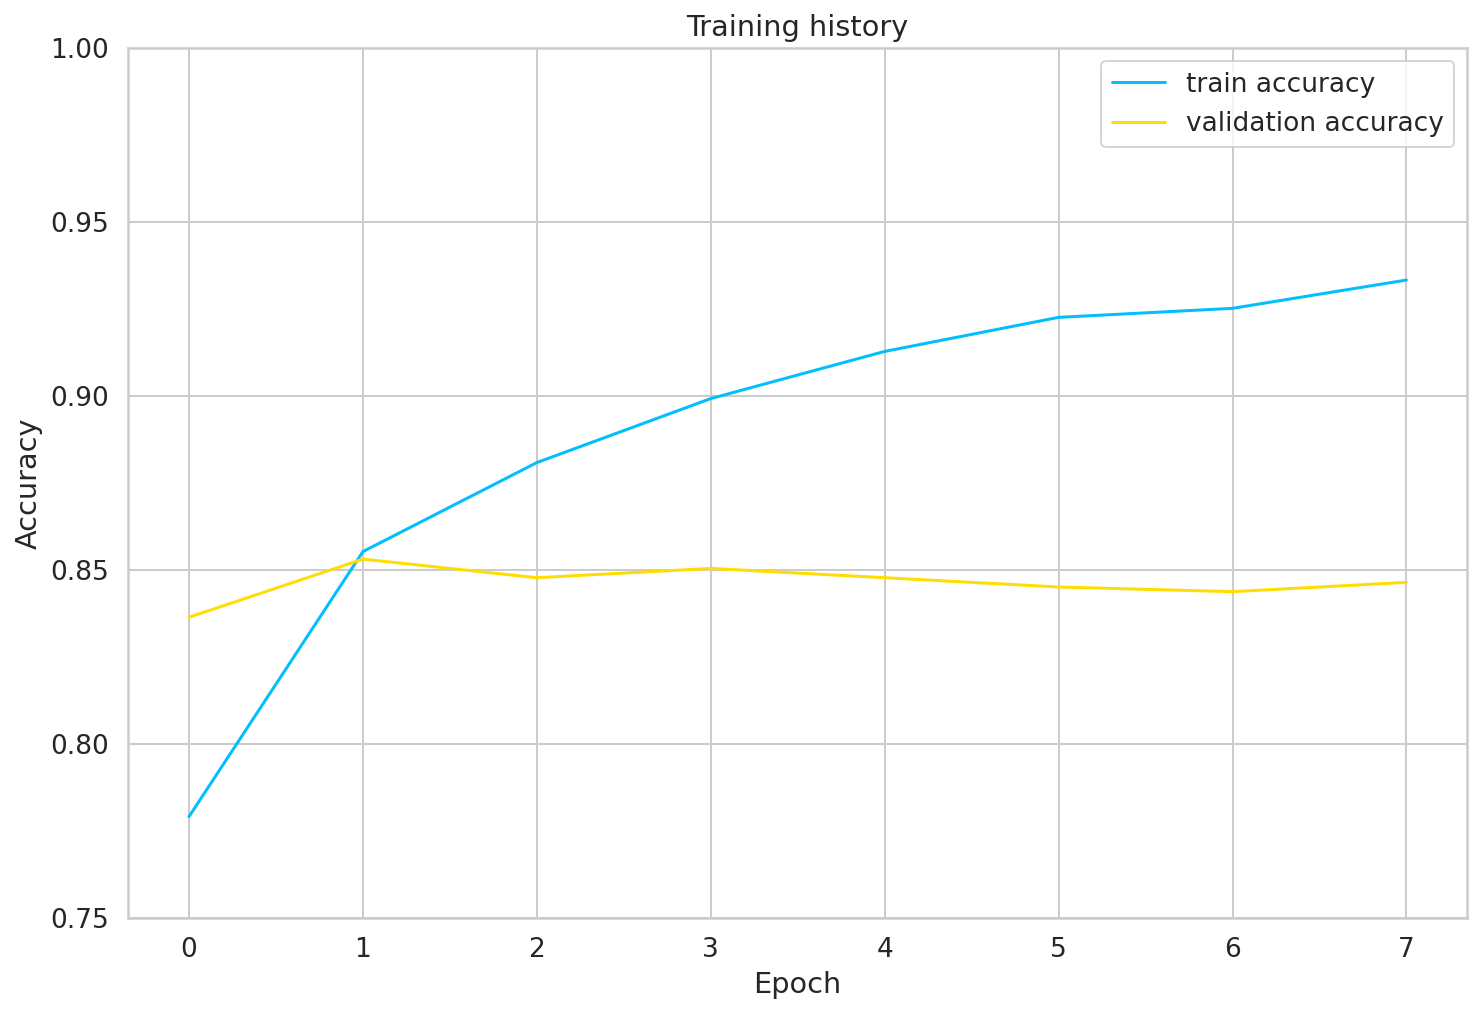

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.75, 1.0]);

In [ ]:
model3 = SentimentClassifier(2)
model3.load_state_dict(torch.load('best_model3_state.bin'))
model3 = model3.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
test_acc, test_loss = eval_model(
  model3,
  test_data_loader,
  loss_fn,
  device,
  len(test_dataset)
)

In [ ]:
test_acc.item()

0.8327196212519726

In [ ]:
test_loss

0.4356373767329364

In [ ]:
y_review_texts, y3_pred, y3_pred_proba, y3_test = get_predictions(
  model3,
  test_data_loader
)

tensor([[ 2.0059, -1.0365],
        [-0.1014,  1.1171],
        [ 1.9163, -0.7715],
        [ 2.2377, -1.0400],
        [ 2.3780, -1.2223],
        [ 2.8857, -2.1162],
        [ 2.2648, -1.0761],
        [-1.1514,  2.1851],
        [-1.0744,  1.9174],
        [ 2.7774, -1.8742],
        [-1.4088,  2.3831],
        [ 2.2581, -1.4672],
        [ 1.5901, -0.5133],
        [ 2.4240, -1.5206],
        [-1.3027,  2.1467],
        [-1.2486,  2.1234]], device='cuda:0')


In [ ]:
y3_pred

tensor([0, 1, 0,  ..., 0, 1, 1])

In [ ]:
y3_pred_proba

tensor([[0.9545, 0.0455],
        [0.2282, 0.7718],
        [0.9363, 0.0637],
        ...,
        [0.9688, 0.0312],
        [0.0163, 0.9837],
        [0.0115, 0.9885]])

In [ ]:
y3_test

tensor([0, 0, 1,  ..., 1, 1, 1])

In [ ]:
conf_mx = confusion_matrix(y3_test, y3_pred)

In [ ]:
conf_mx

array([[931, 185],
       [133, 652]])

In [ ]:
precision3 = precision_score(y3_test, y3_pred)

In [ ]:
precision3

0.7789725209080047

In [ ]:
recall3 = recall_score(y3_test, y3_pred)

In [ ]:
recall3

0.8305732484076433

In [ ]:
f1_score3 = f1_score(y3_test, y3_pred)
f1_score3

0.8039457459926017

##### Classifier 4

In [ ]:
train_data_loader = create_data_loader(train_dataset.content.to_numpy(), train_dataset.more_than_4_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_dataset.content.to_numpy(), val_dataset.more_than_4_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset.content.to_numpy(), test_dataset.more_than_4_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model4 = SentimentClassifier(2)
model4 = model4.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
EPOCHS = 8
optimizer = AdamW(model4.parameters(), lr=7e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(
    model4,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_dataset)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')  

  val_acc, val_loss = eval_model(
    model4,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  
  PATH = 'train_valid-epoch{}.pth'.format(epoch)
  
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model4.state_dict(), 'best_model4_state.bin')
    best_accuracy = val_acc

Epoch 1/8
------------------------------
Train loss 0.3813174807671773 accuracy 0.8456549935149157
Val   loss 0.3707176236475402 accuracy 0.8543754175016701

Epoch 2/8
------------------------------
Train loss 0.29168927071794953 accuracy 0.884801320598986
Val   loss 0.3927021065845768 accuracy 0.8476953907815632

Epoch 3/8
------------------------------
Train loss 0.2569097077023245 accuracy 0.9037849310222851
Val   loss 0.39083618006886955 accuracy 0.8597194388777556

Epoch 4/8
------------------------------
Train loss 0.23308433264558837 accuracy 0.9199386864756514
Val   loss 0.4729160032076563 accuracy 0.850367401469606

Epoch 5/8
------------------------------
Train loss 0.21820430303599314 accuracy 0.9288998938804386
Val   loss 0.5141287690791441 accuracy 0.8577154308617235

Epoch 6/8
------------------------------
Train loss 0.20206493298828307 accuracy 0.939747671265181
Val   loss 0.5577181798376222 accuracy 0.8530394121576487

Epoch 7/8
------------------------------
Train los

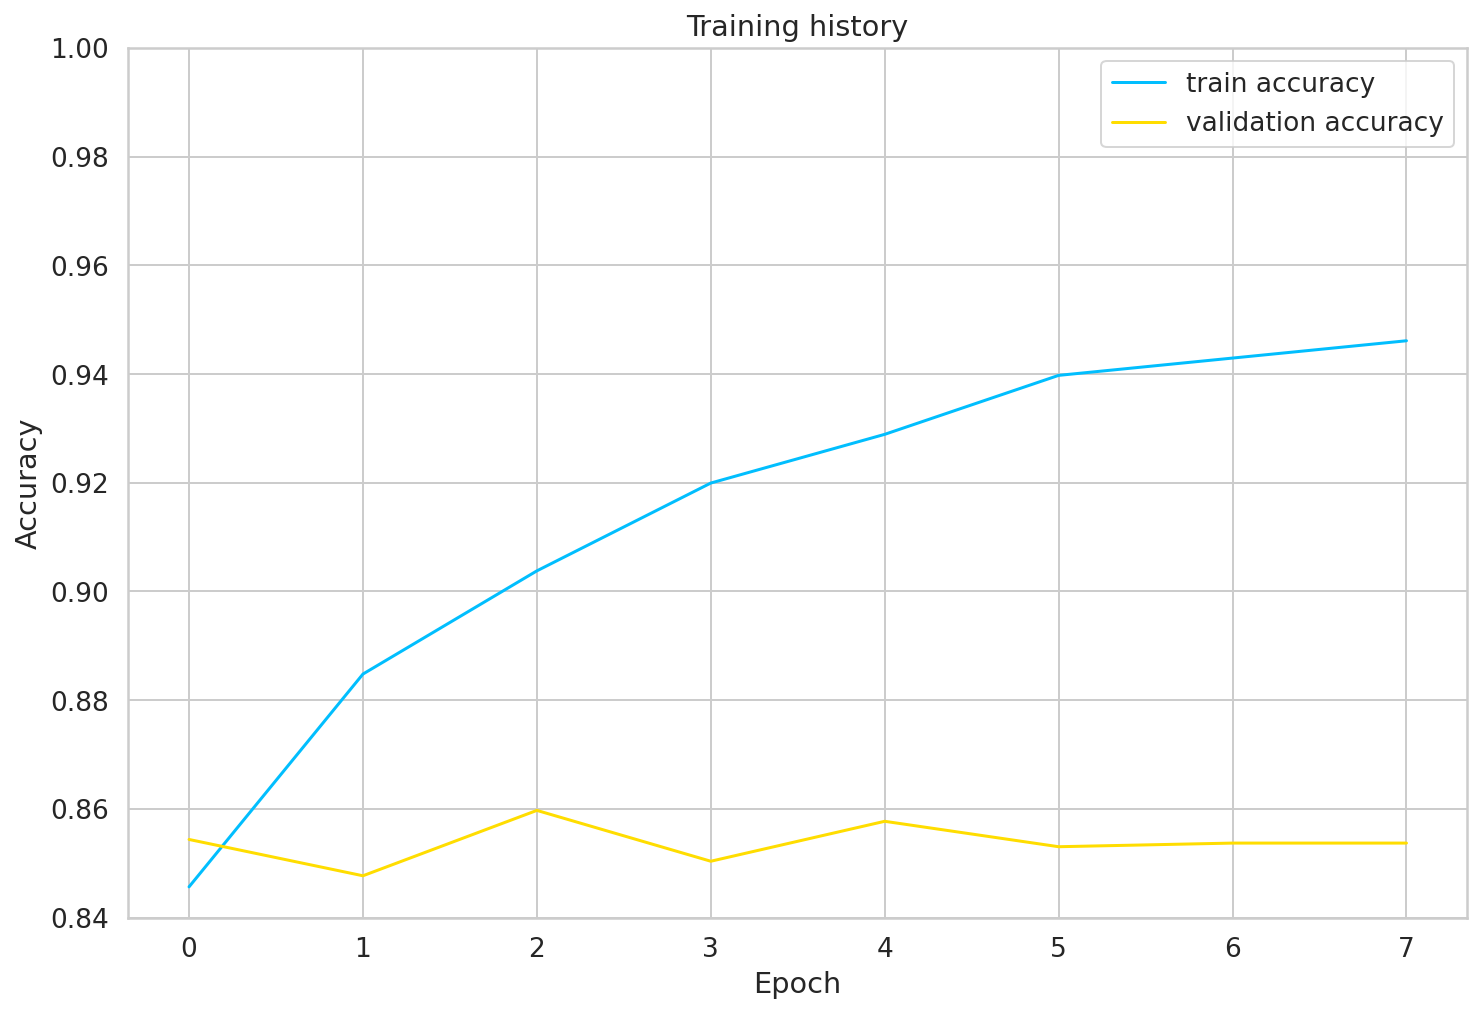

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.84, 1.0]);
# Explain why you run only 7 epochs and stop the running

In [ ]:
model4 = SentimentClassifier(2)
model4.load_state_dict(torch.load('best_model4_state.bin'))
model4 = model4.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
test_acc, test_loss = eval_model(
  model4,
  test_data_loader,
  loss_fn,
  device,
  len(test_dataset)
)

In [ ]:
test_acc.item()

0.8726985796948974

In [ ]:
test_loss

0.3722183979390299

In [ ]:
y_review_texts, y4_pred, y4_pred_proba, y4_test = get_predictions(
  model4,
  test_data_loader
)

tensor([[ 3.1789, -3.3179],
        [ 2.5928, -2.8473],
        [ 1.0014, -1.7278],
        [ 2.0029, -2.8165],
        [ 3.1116, -3.0764],
        [ 3.0534, -2.8674],
        [ 2.9432, -3.0366],
        [ 0.9393, -1.3392],
        [ 0.5722, -0.9759],
        [ 3.0747, -3.0957],
        [-0.3758,  0.3143],
        [ 3.0758, -2.9015],
        [ 0.5097, -0.8047],
        [ 2.7791, -2.6856],
        [ 0.7316, -1.1649],
        [ 3.0958, -2.9776]], device='cuda:0')


In [ ]:
y4_pred

tensor([0, 0, 0,  ..., 0, 1, 1])

In [ ]:
y4_pred_proba

tensor([[0.9985, 0.0015],
        [0.9957, 0.0043],
        [0.9387, 0.0613],
        ...,
        [0.9729, 0.0271],
        [0.2129, 0.7871],
        [0.0436, 0.9564]])

In [ ]:
y4_test

tensor([0, 0, 0,  ..., 1, 1, 1])

In [ ]:
conf_mx = confusion_matrix(y4_test, y4_pred)

In [ ]:
conf_mx

array([[1372,  116],
       [ 126,  287]])

In [ ]:
precision4 = precision_score(y4_test, y4_pred)

In [ ]:
precision4

0.7121588089330024

In [ ]:
recall4 = recall_score(y4_test, y4_pred)

In [ ]:
recall4

0.6949152542372882

In [ ]:
f1_score4 = f1_score(y4_test, y4_pred)
f1_score4

0.7034313725490197

In [ ]:
import numpy as np

In [ ]:
def ordinal_classification_predict(binary_predictions):
  classes_proba = []
  classes_proba.append(1-binary_predictions[0][1])
  classes_proba.append(binary_predictions[0][1]-binary_predictions[1][1])
  classes_proba.append(binary_predictions[1][1]-binary_predictions[2][1])
  classes_proba.append(binary_predictions[2][1]-binary_predictions[3][1])
  classes_proba.append(binary_predictions[3][1])

  return np.argmax(classes_proba)
  

In [ ]:
def ordinal_classification_predict_proba(binary_predictions):
  class1 = (1-binary_predictions[0][1])
  class2 = (binary_predictions[0][1]-binary_predictions[1][1])
  class3 = (binary_predictions[1][1]-binary_predictions[2][1])
  class4 = (binary_predictions[2][1]-binary_predictions[3][1])
  class5 = (binary_predictions[3][1])

  return [class1, class2, class3, class4, class5]

In [ ]:
y1_series = pd.Series(y1_pred_proba)
y2_series = pd.Series(y2_pred_proba)
y3_series = pd.Series(y3_pred_proba)
y4_series = pd.Series(y4_pred_proba)

binary_preds = { 'more_than_1_star': y1_series,
                 'more_than_2_star': y2_series,
                 'more_than_3_star': y3_series,
                 'more_than_4_star': y4_series}
binary_preds_df = pd.DataFrame(binary_preds)

In [ ]:
binary_preds_df.head()

,more_than_1_star,more_than_2_star,more_than_3_star,more_than_4_star
0,"(tensor(0.0912), tensor(0.9088))","(tensor(0.9876), tensor(0.0124))","(tensor(0.9545), tensor(0.0455))","(tensor(0.9985), tensor(0.0015))"
1,"(tensor(0.0332), tensor(0.9668))","(tensor(0.0053), tensor(0.9947))","(tensor(0.2282), tensor(0.7718))","(tensor(0.9957), tensor(0.0043))"
2,"(tensor(0.0902), tensor(0.9098))","(tensor(0.3009), tensor(0.6991))","(tensor(0.9363), tensor(0.0637))","(tensor(0.9387), tensor(0.0613))"
3,"(tensor(0.1386), tensor(0.8614))","(tensor(0.6179), tensor(0.3821))","(tensor(0.9637), tensor(0.0363))","(tensor(0.9920), tensor(0.0080))"
4,"(tensor(0.3548), tensor(0.6452))","(tensor(0.9837), tensor(0.0163))","(tensor(0.9734), tensor(0.0266))","(tensor(0.9980), tensor(0.0020))"


In [ ]:
y_pred = binary_preds_df.apply(lambda row: ordinal_classification_predict(row), axis=1)

In [ ]:
y_pred_proba = binary_preds_df.apply(lambda row: ordinal_classification_predict_proba(row), axis=1)

In [ ]:
y_pred.values

array([1, 3, 2, ..., 1, 4, 4])

In [ ]:
y_pred_proba = np.stack(y_pred_proba.values)
y_pred_proba

array([[ 0.09115732,  0.8964247 , -0.0331262 ,  0.04403815,  0.00150599],
       [ 0.03320694, -0.02794874,  0.22295499,  0.7674668 ,  0.00432   ],
       [ 0.09020382,  0.21070784,  0.63538843,  0.00242821,  0.0612717 ],
       ...,
       [ 0.317559  ,  0.66434145, -0.0130796 ,  0.00408503,  0.02709409],
       [ 0.02957284, -0.02485096,  0.01155436,  0.1966694 ,  0.78705436],
       [ 0.02466881, -0.02366215,  0.01044941,  0.03212595,  0.956418  ]],
      dtype=float32)

In [ ]:
y_test = test_dataset["score"]
y_test.values

array([2, 2, 3, ..., 4, 4, 4])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.4907943187795897

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

array([[157, 129,  42,  10,   5],
       [ 57, 179,  96,  38,   6],
       [ 22, 125, 135,  96,  19],
       [  3,  21,  82, 173,  93],
       [  3,  17,   9,  95, 289]])

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="f", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');


In [ ]:
class_names = ['strongly_neg','neg','neutral','pos','strongly_pos']

In [ ]:
import numpy as np

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)
norm_conf_mx = conf_mx / row_sums

[[343]
 [376]
 [397]
 [372]
 [413]]


In [ ]:
norm_conf_mx

array([[0.45772595, 0.37609329, 0.12244898, 0.02915452, 0.01457726],
       [0.15159574, 0.47606383, 0.25531915, 0.10106383, 0.01595745],
       [0.05541562, 0.31486146, 0.34005038, 0.2418136 , 0.04785894],
       [0.00806452, 0.05645161, 0.22043011, 0.46505376, 0.25      ],
       [0.00726392, 0.04116223, 0.02179177, 0.23002421, 0.69975787]])

In [ ]:
df_norm_cm = pd.DataFrame(norm_conf_mx, index=class_names, columns=class_names)

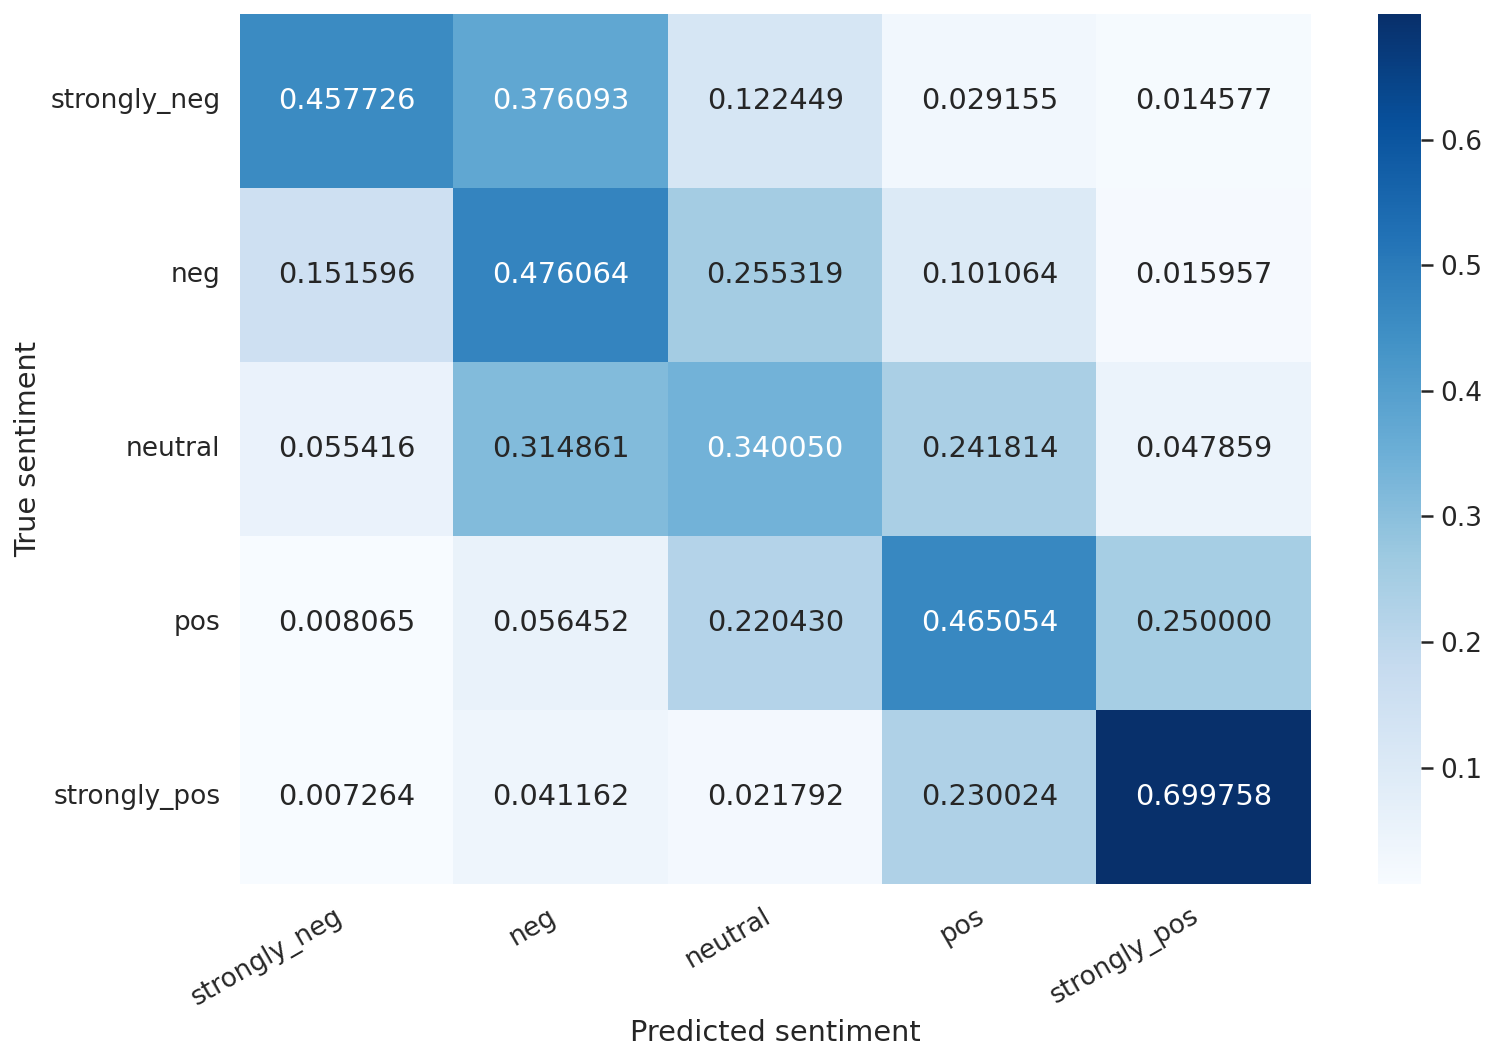

In [ ]:
show_confusion_matrix(df_norm_cm)

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)

In [ ]:
df_norm_cm = pd.DataFrame(norm_conf_mx, index=class_names, columns=class_names)

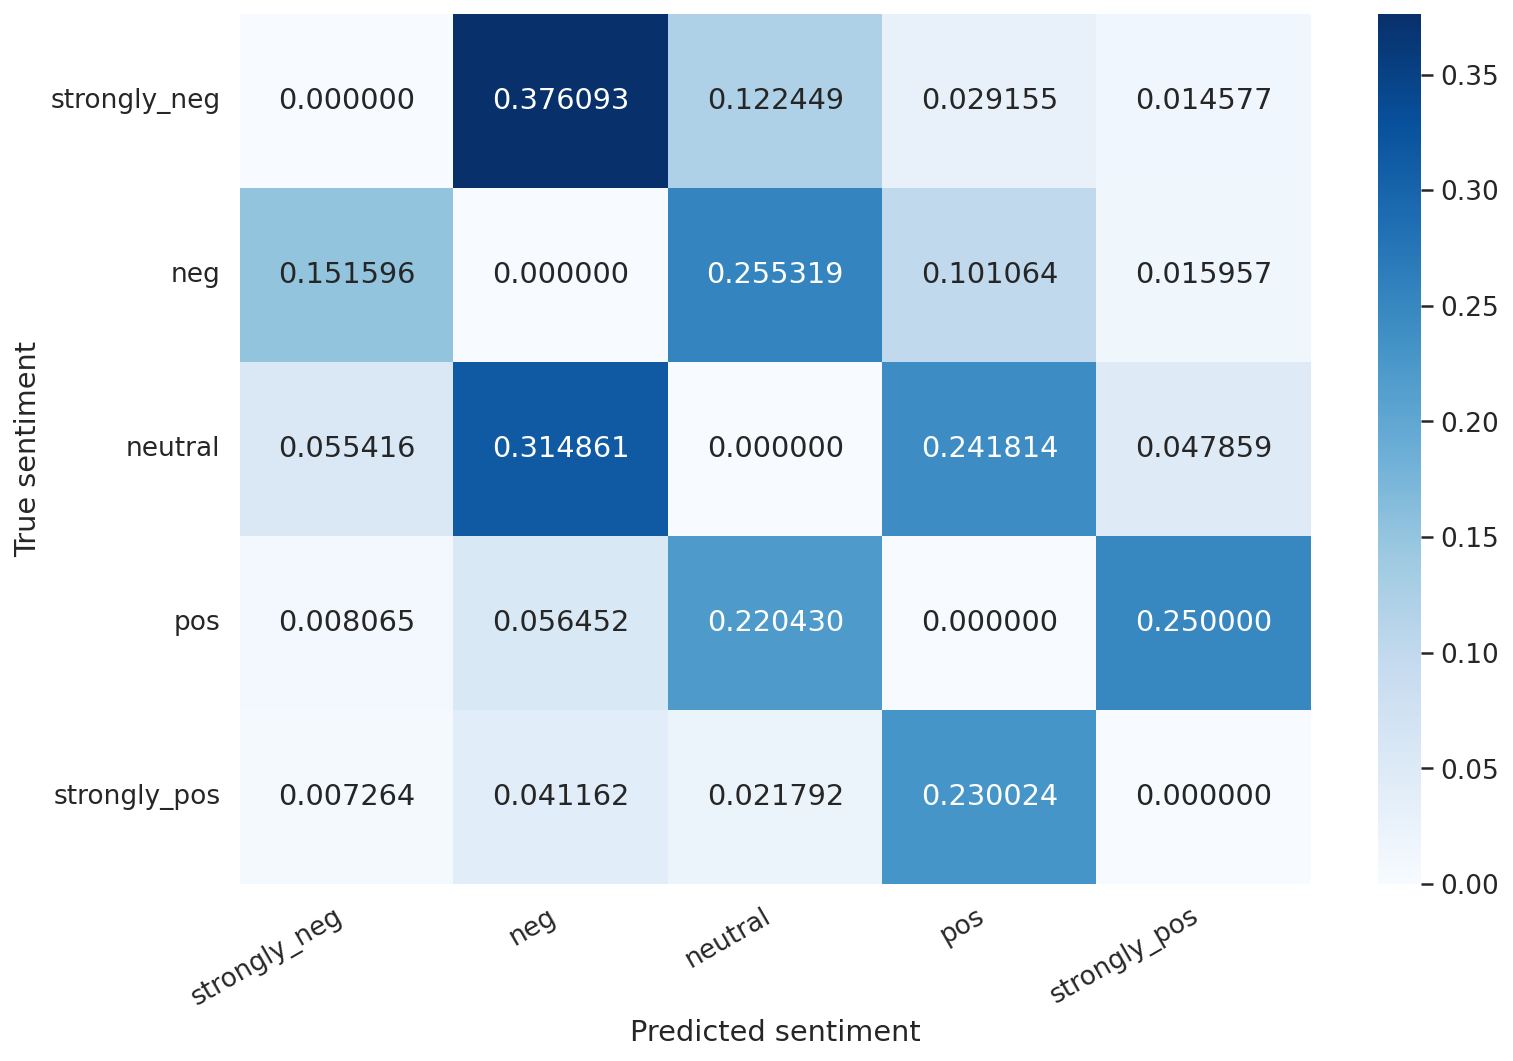

In [ ]:
show_confusion_matrix(df_norm_cm)

Precison / Recall

In [ ]:
from sklearn.preprocessing import label_binarize

In [ ]:
# Use label_binarize to be multi-label like settings
y_test_mult = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
print(y_test_mult)
print(y_pred_proba)

n_classes = y_test_mult.shape[1]
n_classes

[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
[[ 0.09115732  0.8964247  -0.0331262   0.04403815  0.00150599]
 [ 0.03320694 -0.02794874  0.22295499  0.7674668   0.00432   ]
 [ 0.09020382  0.21070784  0.63538843  0.00242821  0.0612717 ]
 ...
 [ 0.317559    0.66434145 -0.0130796   0.00408503  0.02709409]
 [ 0.02957284 -0.02485096  0.01155436  0.1966694   0.78705436]
 [ 0.02466881 -0.02366215  0.01044941  0.03212595  0.956418  ]]


5

In [ ]:
print(len(y_test_mult))
print(len(y_pred_proba))

1901
1901


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [ ]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_mult[:, i],
                                                        y_pred_proba[:, i])
    
    curr_precision = precision[i]
    curr_recall = recall[i]

    precision[i] = precision[i][curr_precision+curr_recall > 0.0]
    recall[i] = recall[i][curr_precision+curr_recall > 0.0]

    average_precision[i] = average_precision_score(y_test_mult[:, i], y_pred_proba[:, i])

In [ ]:
# A "macro-average": Averaging over classes
# ====> Cannot do macro-average by the below approach because:
# len(precision[i]) depend on i (the unique probas in column i)
# the thresholds that based on it the precision & recall are calculated is not the same at the corresponding indices
#precision_sum = precision[0] + precision[1] + precision[2] + precision[3] + precision[4]
#precision["macro"] = precision_sum / 5
#recall_sum = recall[0] + recall[1] + recall[2] + recall[3] + recall[4]
#recall["macro"] = recall_sum / 5

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_mult.ravel(),
    y_pred_proba.ravel())


# compute F1 score
f1_score = dict()
# for each class
for i in range(n_classes):
  f1_score[i] = 2*((precision[i]*recall[i])/(precision[i]+recall[i]))

f1_score["micro"] = 2*((precision["micro"]*recall["micro"])/(precision["micro"]+recall["micro"]))

In [ ]:
average_precision["micro"] = average_precision_score(y_test_mult, y_pred_proba,
                                                     average="micro")
average_precision["macro"] = average_precision_score(y_test_mult, y_pred_proba,
                                                     average="macro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))
print('Average precision score, macro-averaged over all classes: {0:0.2f}'
      .format(average_precision["macro"]))

Average precision score, micro-averaged over all classes: 0.49
Average precision score, macro-averaged over all classes: 0.50


Plot the micro-averaged Precision-Recall curve

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.49')

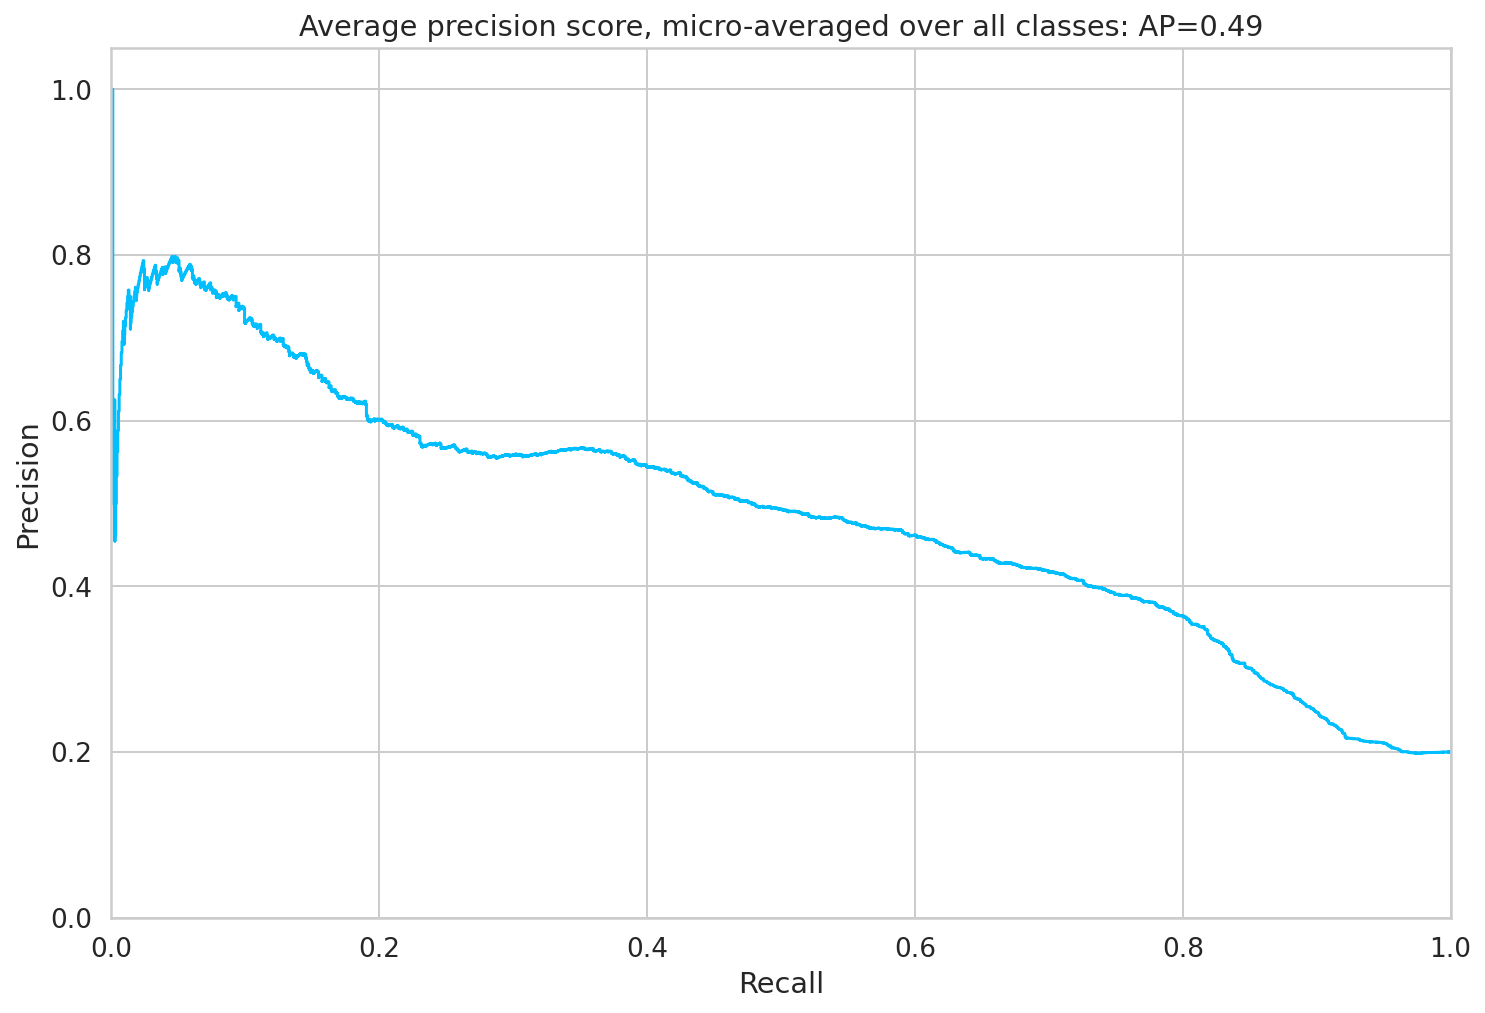

In [ ]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

Plot Precision-Recall curve for each class and iso-f1 curves

In [ ]:
from itertools import cycle

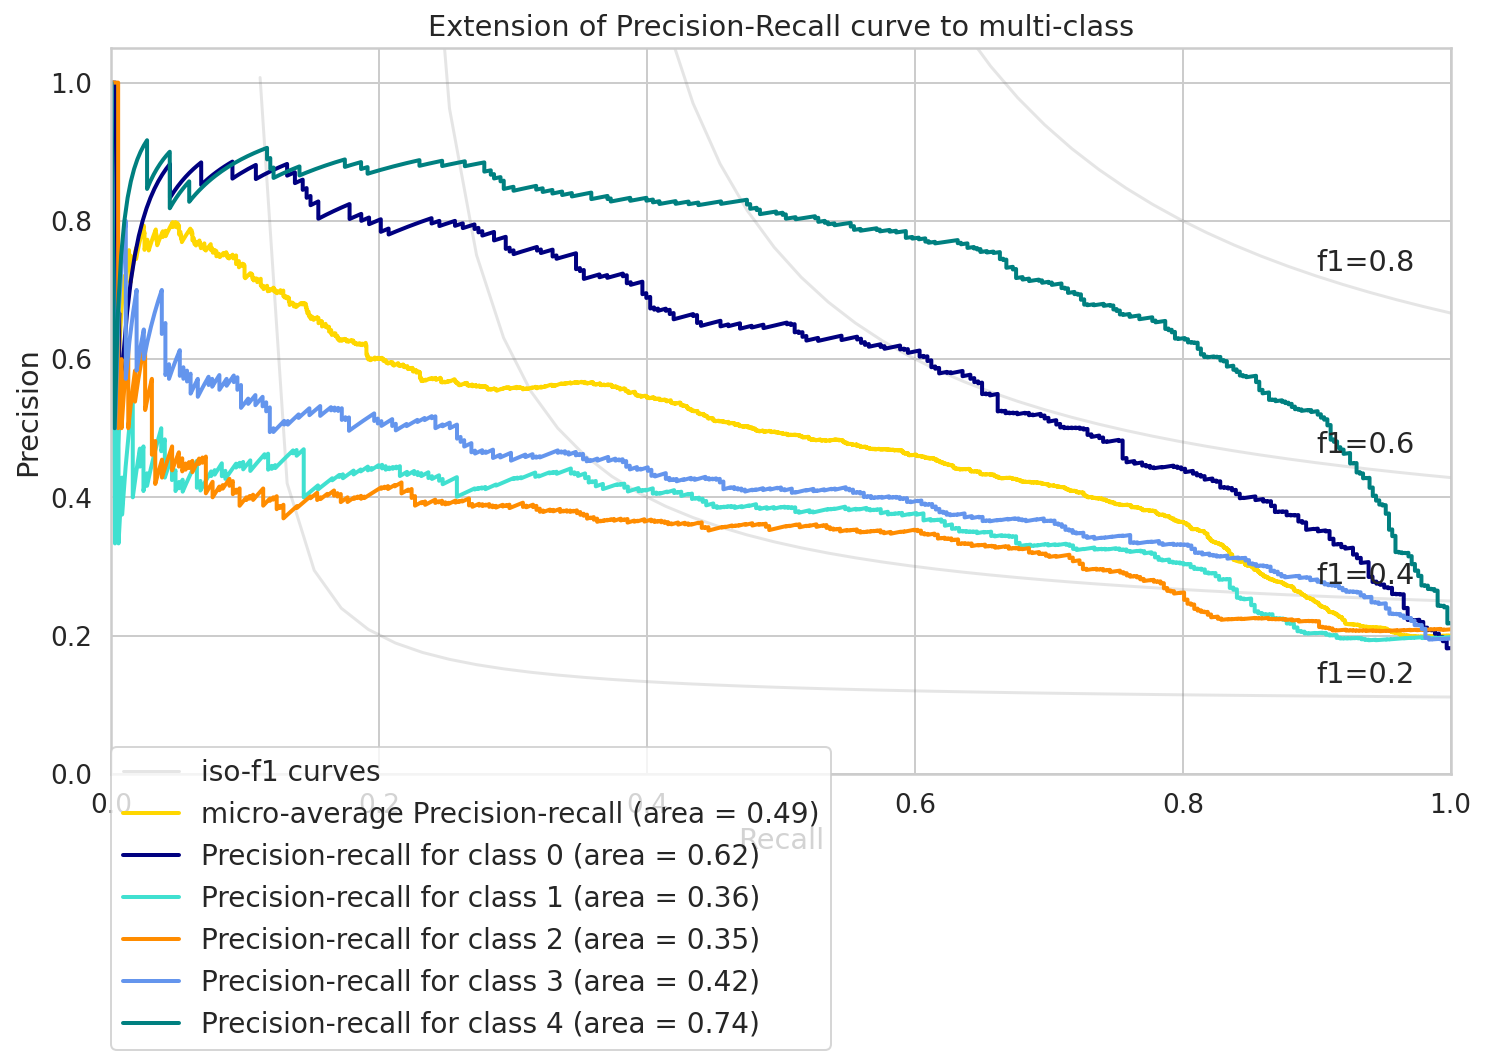

In [ ]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(12, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()
